<a href="https://colab.research.google.com/github/kibutan/Atcoder/blob/master/Signate_294_%E5%82%B5%E5%8B%99%E4%B8%8D%E5%B1%A5%E8%A1%8C%E3%83%AA%E3%82%B9%E3%82%AF%E3%81%AE%E4%BD%8E%E6%B8%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%pip install signate

In [19]:
#kaggle.jsonをGoogle Drive からひっぱってくるやつ
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!signate list

  competitionId  title                                                              closing     prize                             submitters
---------------  -----------------------------------------------------------------  ----------  ------------------------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                               -                                                   4186
             24  【練習問題】お弁当の需要予測                                       -                                                   4966
             27  【練習問題】Jリーグの観客動員数予測                                -                                                   1040
            100  【練習問題】手書き文字認識                                         -           Knowledge                                103
            102  【練習問題】タイタニックの生存予測                                 -           Knowledge                                405
            103  【練習問題】音楽ラベリング                                         -           Knowledge

In [20]:
#規約同意前ならエラーを返す。yを入力後再実行でダウンロードが可能に。
#指定しない限り、カレントディレクトリにデータは降りる。
!signate download -c 294

submit.csv

test.csv

train.csv


Download completed.


In [ ]:
!ls

 adc.json      submission.csv	 submit.csv	 test.csv	  train.csv
 sample_data  'submit (1).csv'	'test (1).csv'	'train (1).csv'


https://www.kaggle.com/sishihara/upura-kaggle-tutorial-02-overview
を参考にsubmitまでの流れを掴んで見る


必要なパッケージの読み込み

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submit = pd.read_csv("submit.csv",header=None)


データの確認

In [ ]:
print(submit.dtypes)

0    int64
1    int64
dtype: object


In [ ]:
train.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,88194295,1800.0,3 years,14.49,C4,NaN,debt_consolidation,665.0,Individual,FullyPaid
1,5146039,1200.0,5 years,16.29,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff
2,3095896,2000.0,5 years,21.98,E4,10 years,home_improvement,670.0,Individual,FullyPaid
3,88625044,1000.0,3 years,8.59,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid
4,1178189,1500.0,3 years,13.99,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid


In [ ]:
test

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type
0,1496754,1912.5,3 years,10.16,B1,5 years,debt_consolidation,725.0,Individual
1,84909594,1800.0,3 years,8.99,B1,9 years,credit_card,695.0,Individual
2,1165403,550.0,3 years,14.65,C2,10 years,credit_card,660.0,Individual
3,91354446,2000.0,5 years,15.59,C5,10 years,credit_card,695.0,Individual
4,85636932,1500.0,5 years,12.79,C1,0 years,medical,720.0,Individual
...,...,...,...,...,...,...,...,...,...
26901,5064630,800.0,3 years,7.90,A4,5 years,debt_consolidation,735.0,Individual
26902,94416733,750.0,3 years,7.49,A4,8 years,debt_consolidation,715.0,Individual
26903,120604638,840.0,3 years,15.05,C4,7 years,car,695.0,Individual
26904,1110314,1000.0,3 years,14.27,C2,0 years,debt_consolidation,680.0,Individual


Quest とCompで中身が違う可能性があるので中身を精査したい

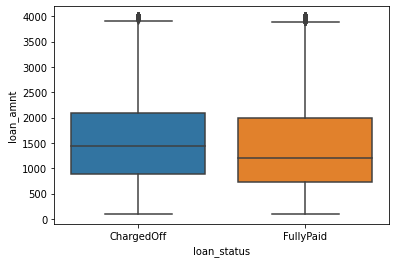

In [7]:
#Loan amount
loans = train[(train['loan_status'] == 'FullyPaid') | (train['loan_status'] == 'ChargedOff')]
loans = loans.drop(columns=['id'])
loans = loans.dropna()

# 箱ひげ図を作成
sns.boxplot(x = "loan_status",y = "loan_amnt", data = loans)
#図次するとあまり関係はなさそう

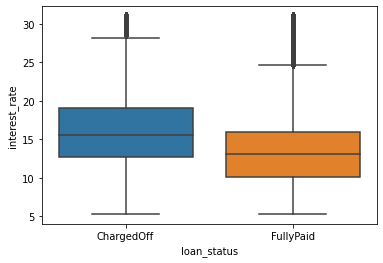

In [ ]:
#credit_score
sns.boxplot(x = "loan_status",y = "interest_rate",data = loans)
# 金利が高いとC\rateも高い

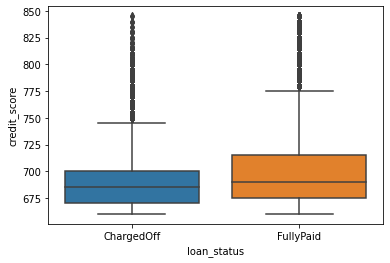

In [ ]:
#credit_score
sns.boxplot(x = "loan_status",y = "credit_score",data = loans)

loan_status  ChargedOff  FullyPaid     All    c_rate    f_rate
term                                                          
3 years           29339     148241  177580  0.165216  0.834784
5 years           15206      36185   51391  0.295888  0.704112


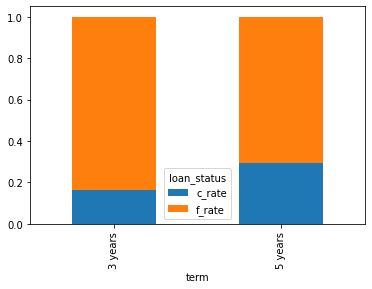

In [8]:
# term
cross_term = pd.crosstab(loans["term"],loans["loan_status"],margins = True)
# ChargedOffカラムをAllカラムで割り、変数c_rateに代入
c_rate = cross_term["ChargedOff"]/cross_term["All"]

# FullyPaidカラムをAllカラムで割り、変数f_rateに代入
f_rate = cross_term["FullyPaid"]/cross_term["All"]


# 変数c_rate及び変数f_rateを変数cross_termに新たなカラムc_rate、f_rateとしてそれぞれ代入
cross_term['c_rate'] = c_rate
cross_term['f_rate'] = f_rate
# クロス集計表の表示
cross_term = cross_term.drop(index = ['All'])
print(cross_term)
# 積み上げ棒グラフに使用したいカラムだけのDataFrameを作成
df_bar = cross_term[["c_rate","f_rate"]]
# 積み上げ棒グラフを作成
df_bar.plot.bar(stacked=True)
# グラフタイトルの設定
#plt.title("返済期間ごとの貸し倒れ率と完済率")
# x軸ラベルの設定
#plt.xlabel("期間")
# y軸ラベルの設定
#plt.ylabel("割合")
# グラフの表示
plt.show()

#5年借りる方がc_rate高い

loan_status  ChargedOff  FullyPaid    All    c_rate    f_rate
grade                                                        
A1                  194       5316   5510  0.035209  0.964791
A2                  244       5128   5372  0.045421  0.954579
A3                  337       5486   5823  0.057874  0.942126
A4                  539       6916   7455  0.072300  0.927700
A5                  744       8054   8798  0.084565  0.915435
B1                 1320      11180  12500  0.105600  0.894400
B2                 1483      12244  13727  0.108035  0.891965
B3                 1966      14094  16060  0.122416  0.877584
B4                 2319      13709  16028  0.144684  0.855316
B5                 2677      12327  15004  0.178419  0.821581
C1                 3009      12655  15664  0.192097  0.807903
C2                 2725      10887  13612  0.200191  0.799809
C3                 2710       9679  12389  0.218742  0.781258
C4                 3088       9893  12981  0.237886  0.762114
C5      

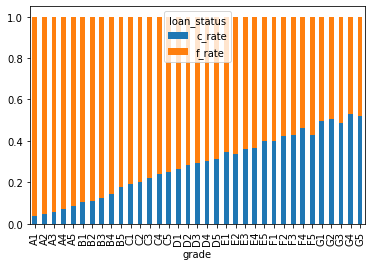

In [ ]:
# interest_rate
cross_term = pd.crosstab(loans["grade"],loans["loan_status"],margins = True)
# ChargedOffカラムをAllカラムで割り、変数c_rateに代入
c_rate = cross_term["ChargedOff"]/cross_term["All"]

# FullyPaidカラムをAllカラムで割り、変数f_rateに代入
f_rate = cross_term["FullyPaid"]/cross_term["All"]


# 変数c_rate及び変数f_rateを変数cross_termに新たなカラムc_rate、f_rateとしてそれぞれ代入
cross_term['c_rate'] = c_rate
cross_term['f_rate'] = f_rate
# クロス集計表の表示
cross_term = cross_term.drop(index = ['All'])
print(cross_term)
# 積み上げ棒グラフに使用したいカラムだけのDataFrameを作成
df_bar = cross_term[["c_rate","f_rate"]]
# 積み上げ棒グラフを作成
df_bar.plot.bar(stacked=True)
# グラフタイトルの設定
#plt.title("返済期間ごとの貸し倒れ率と完済率")
# x軸ラベルの設定
#plt.xlabel("期間")
# y軸ラベルの設定
#plt.ylabel("割合")
# グラフの表示
plt.show()

# Gradeが低いとC_rateが高い


特徴量エンジニアリング
NaNや文字列などの値を数値に置き換えるなど行っていく。不要なデータを検討し、Dropする。

In [ ]:
#関数同士の相関を調べる
#df = pd.DataFrame(train)
#df_corr = df.corr()
#print(df_corr)

In [22]:
train["loan_status"] = train["loan_status"].map({"FullyPaid":0,"ChargedOff":1}).astype(int)

In [23]:
data = pd.concat([train, test],sort = False)

In [24]:
print(len(train), len(test), len(data))
if(len(train)+len(test) ==  len(data)):print("Yes")

242156 26906 269062
Yes


In [ ]:
data.isnull().sum()

id                       0
loan_amnt                0
term                     0
interest_rate            0
grade                    0
employment_length    14625
purpose                  0
credit_score             0
application_type         0
loan_status          26906
dtype: int64

credit_card
debt_consolidation
home_improvement
house
major_purchase
medical
moving
other
renewable_energy
small_business
vacation
wedding
どの変数がローンの返済に係るか分からないのでわちゃわちゃする
* term
  * 3 years...16%
  * 5 years...30%
* interest_rate
  * mid...15%(C)
  * mid...13%(F)
* grade
  * A1...3%
  * G2...54% 
* purpose
  * wedding...12%
  * small_business...32%
* credit_score

* application_type
  * Individual...19%
  * Joint App...25%
         



In [25]:
delete_columns = ["id","loan_amnt","employment_length"]
#delete_columns = ["id","loan_amnt","employment_length","term","grade","purpose","application_type"]
data.drop(delete_columns, axis = 1, inplace =True)

# 各変数について数値化、量的データの変換などを行う
term, grade, purpose, application_typeは何かしらの変更が必要。TermやApplicationは0,1でいい。PurposeやGradeはしきい値を定めて0,1にするといいのか？



interest_rate, credit_scoreは無加工にて学習に突っ込める

C_rateｍになりやすそうな方を1、そうでない方を0としてみる。

In [26]:
data['term'] = data['term'].map( {'3 years': 0, '5 years': 1,} ).astype(int)
data['application_type'] = data['application_type'].map( {'Individual': 0, 'Joint App': 1,} ).astype(int)
#かんたんな方

In [27]:
data['purpose'] = data['purpose'].map( {'car':0,"credit_card":0,"debt_consolidation":1,"home_improvement":0,"house":1,"major_purchase":0,"medical":1,"moving":1,"other":1,"renewable_energy":1,"small_business":1,"vacation":0,"wedding": 0} ).astype(int)
#なんとなく、もくてき別貸し倒れ率が20％を超えているものを1、そうでないものを0とした。

data['grade'] = data['grade'].map( {'A1': 0, 'A2': 0,'A3': 0, 'A4': 0,'A5': 0, 'B1': 0,'B2': 0, 'B3': 0,'B4': 0, 'B5': 0,
                                    'C1': 1, 'C2': 1,'C3': 1, 'C4': 1,'C5': 1, 'D1': 1,'D2': 1, 'D3': 1,'D4': 1, 'D5': 1,
                                    'E1': 1, 'E2': 1,'E3': 1, 'E4': 1,'E5': 1, 'F1': 1,'F2': 1, 'F3': 1,'F4': 1, 'F5': 1,
                                    'G1': 1, 'G2': 1,'G3': 1, 'G4': 1,'G5': 1} ).astype(int)
#なんとなく、C2が20%の貸し倒れ率なので、Cランク以下は全部1とする。

#めんどくさい方

In [ ]:

# data_dam = pd.get_dummies(data)
# data_dam.head()

,term_3 years,term_5 years,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F1,grade_F2,grade_F3,grade_F4,grade_F5,grade_G1,grade_G2,grade_G3,grade_G4,grade_G5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App,loan_status_ChargedOff,loan_status_FullyPaid
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [28]:
train = data[:len(train)]
test = data[len(train):]

In [29]:
y_train = train["loan_status"]
X_train = train.drop("loan_status", axis =1)
X_test = test.drop("loan_status",axis =1)

In [30]:
y_train

0         0.0
1         1.0
2         0.0
3         0.0
4         0.0
         ... 
242151    0.0
242152    1.0
242153    0.0
242154    0.0
242155    0.0
Name: loan_status, Length: 242156, dtype: float64

In [ ]:
X_train

,term,interest_rate,grade,purpose,credit_score,application_type
0,0,14.49,1,1,665.0,0
1,1,16.29,1,1,700.0,0
2,1,21.98,1,0,670.0,0
3,0,8.59,0,1,710.0,0
4,0,13.99,1,1,680.0,0
...,...,...,...,...,...,...
242151,0,10.16,0,1,690.0,0
242152,0,12.74,1,1,695.0,0
242153,0,14.08,1,1,730.0,0
242154,0,19.72,1,0,685.0,0


In [ ]:
X_test

,term,interest_rate,grade,purpose,credit_score,application_type
0,0,10.16,0,1,725.0,0
1,0,8.99,0,0,695.0,0
2,0,14.65,1,0,660.0,0
3,1,15.59,1,0,695.0,0
4,1,12.79,1,1,720.0,0
...,...,...,...,...,...,...
26901,0,7.90,0,1,735.0,0
26902,0,7.49,0,1,715.0,0
26903,0,15.05,1,0,695.0,0
26904,0,14.27,1,1,680.0,0


In [31]:
#clf の値は適当12に見えるのは「えるつぅ」。
from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty = 'l2', solver = "sag", random_state=0)
clf = LogisticRegression(random_state=0)

In [32]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
print(y_pred)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(submit.dtypes)

0    int64
1    int64
dtype: object


In [33]:
sub = submit

詰まりポイント

submit と Testの行数が異なっており、予測(y_pred)した後にsubmission.csvにまとめるときにエラーが頻発した。
原因はTestにはIndexが付いているものの、Submitにはそれが無い、というのが大きなエラー出会った。

そこではじめのsubmission.csvをIndex=Falseオプション付きで読ませることで、最初の1列からすでにデータであることを明記し行数をあわせた。

また、採集的な出力であるsubmission.csvもindex,headerともにFalseにして出力ができた(と思いたい)

これをsignateのAPIで提出したいが、さて。

FullPaidを0、 貸し倒れを1として提出必要があるものの、ｙ＿ｐれｄがstrを保持している。
kaggleではそんなこと無いのに、一体どこが変換をしているのか。
もとからSurvived = 0, or 1だった。

y速の前に変換すべきだろうか。
とりあえず、Data= Train+testにする前に変換してみた・。

In [34]:
sub['loan_status'] = list(map(int, y_pred))
sub.drop(sub.columns[[1]],axis=1,inplace = True)
sub.to_csv("submission.csv", index=False , header=False)
print(sub.dtypes)
sub.head()

0              int64
loan_status    int64
dtype: object


,0,loan_status
0,1496754,0
1,84909594,0
2,1165403,0
3,91354446,0
4,85636932,0


In [ ]:
!ls

adc.json  sample_data  submission.csv  submit.csv  test.csv  train.csv


予測値の諸元とかを調べる
ここでy_test(CVセットなど)を作っていれば、f1スコアなど求められるが。

In [36]:
from sklearn.metrics import f1_score
f_one = f1_score(y_test,pred)
print(f_one)

NameError: ignored

In [ ]:
!signate submit -c 294 submission.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.
